In [2]:
!pip -q install --no-cache-dir datasets transformers evaluate accelerate scikit-learn matplotlib


In [38]:
import numpy as np
import pandas as pd

from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding, set_seed)
import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

set_seed(42)


In [40]:
from huggingface_hub import HfApi

def load_turkish_movie_dataset():
    candidates = [
        "mkeskin/turkish_movie_sentiment",
    ]
    for ds_id in candidates:
        try:
            raw = load_dataset(ds_id)
            print("Loaded:", ds_id)
            return ds_id, raw
        except Exception as e:
            print(f"Failed: {ds_id} -> {type(e).__name__}: {e}")

    api = HfApi()
    results = list(api.list_datasets(search="turkish movie sentiment"))
    print("Search results:", len(results))

    for r in results[:40]:
        ds_id = r.id
        try:
            raw = load_dataset(ds_id)
            if "train" in raw:
                print("Auto-found:", ds_id)
                return ds_id, raw
        except Exception:
            pass

    raise RuntimeError("Uygun Türkçe film yorum dataset'i bulunamadı. (Gerekirse CSV yükleyip devam ederiz.)")

ds_id, raw = load_turkish_movie_dataset()
raw


Failed: mkeskin/turkish_movie_sentiment -> RuntimeError: Dataset scripts are no longer supported, but found turkish_movie_sentiment.py
Search results: 4
Auto-found: TFLai/turkish_movie_sentiment


DatasetDict({
    train: Dataset({
        features: ['comment', 'film_name', 'point'],
        num_rows: 83227
    })
})

In [41]:
train_split = raw["train"]
cols = train_split.column_names
print("Columns:", cols)

def infer_columns(ds):
    cols = ds.column_names
    low = {c.lower(): c for c in cols}

    text_candidates = ["text", "review", "comment", "sentence", "content"]
    label_candidates = ["label", "rating", "stars", "score", "point", "puan", "yildiz"]

    text_col = None
    for k in text_candidates:
        if k in low:
            text_col = low[k]; break

    label_col = None
    for k in label_candidates:
        if k in low:
            label_col = low[k]; break

    # ilk string kolonu text yapıyoruz
    if text_col is None:
        for c in cols:
            try:
                if ds.features[c].dtype == "string":
                    text_col = c
                    break
            except Exception:
                pass

    if text_col is None or label_col is None:
        raise ValueError(f"Kolonlar tespit edilemedi. Bulunan text={text_col}, label={label_col}. Kolonlar={cols}")

    return text_col, label_col

text_col, label_col = infer_columns(train_split)
print("Detected text_col:", text_col, "| label_col:", label_col)

print("Sample text:", train_split[0][text_col])
print("Sample label:", train_split[0][label_col])


Columns: ['comment', 'film_name', 'point']
Detected text_col: comment | label_col: point
Sample text: 
                      Jean Reno denince zaten leon filmi gelir akla izlemeyen kalmamıştır ama kaldıysada ee ne duruyorsun hemen izle :)
        
            
Sample label: 5,0


In [42]:
import re
import numpy as np

def to_5class_label(x):
    #  int ise bunu
    if isinstance(x, (int, np.integer)):
        if 0 <= x <= 4:
            return int(x)
        if 1 <= x <= 5:
            return int(x - 1)

    #  float ise bunu
    if isinstance(x, (float, np.floating)):
        y = int(round(float(x)))
        y = max(1, min(5, y))
        return y - 1

    # string ise bunu
    if isinstance(x, str):
        s = x.strip()

        s = s.replace(" ", "")

        s = s.replace(",", ".")

        s = re.sub(r"[^0-9\.\-]", "", s)

        if s == "" or s == "." or s == "-":
            raise ValueError(f"Boş/Geçersiz label string: {x!r}")

        xf = float(s)
        y = int(round(xf))
        y = max(1, min(5, y))
        return y - 1


    raise ValueError(f"Label dönüştürülemedi: {x} ({type(x)})")


In [28]:
ds_clean = standardize(train_split, text_col, label_col)
ds_clean[0]

{'text': '\n                      Jean Reno denince zaten leon filmi gelir akla izlemeyen kalmamıştır ama kaldıysada ee ne duruyorsun hemen izle :)\n        \n            ',
 'label': 4}

In [29]:
for i in range(10):
    print(train_split[i][label_col])

5,0
5,0
5,0
5,0
5,0
5,0
3,5
4,5
2,5
5,0


In [30]:
tmp = ds_clean.to_pandas()
print(tmp["label"].value_counts().sort_index())

label
0    10067
1    15330
2     5563
3    35872
4    16395
Name: count, dtype: int64


In [43]:
df = ds_clean.to_pandas()

train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})
dataset



DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 66581
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8323
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8323
    })
})

In [44]:
model_name = "dbmdz/bert-base-turkish-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256)

tokenized = dataset.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)


Map:   0%|          | 0/66581 [00:00<?, ? examples/s]

Map:   0%|          | 0/8323 [00:00<?, ? examples/s]

Map:   0%|          | 0/8323 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [47]:
training_args = TrainingArguments(
    output_dir="berturk_movie_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    fp16=True,
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-1344262648.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.116600,0.976389,0.610477,0.535921
2,0.853200,0.974733,0.624174,0.557518
3,0.814300,1.017012,0.615884,0.553682


TrainOutput(global_step=12486, training_loss=0.9113647623473056, metrics={'train_runtime': 2212.8814, 'train_samples_per_second': 90.264, 'train_steps_per_second': 5.642, 'total_flos': 2.097563699400903e+16, 'train_loss': 0.9113647623473056, 'epoch': 3.0})

In [48]:
test_metrics = trainer.evaluate(tokenized["test"])
print("TEST METRICS:", test_metrics)

pred = trainer.predict(tokenized["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print(classification_report(y_true, y_pred, digits=4))

TEST METRICS: {'eval_loss': 0.9806875586509705, 'eval_accuracy': 0.6185269734470744, 'eval_macro_f1': 0.546889419380681, 'eval_runtime': 34.0004, 'eval_samples_per_second': 244.791, 'eval_steps_per_second': 7.676, 'epoch': 3.0}
              precision    recall  f1-score   support

           0     0.6352    0.6743    0.6541      1007
           1     0.5211    0.4266    0.4692      1533
           2     0.4970    0.2950    0.3702       556
           3     0.6496    0.8149    0.7230      3588
           4     0.6224    0.4436    0.5180      1639

    accuracy                         0.6185      8323
   macro avg     0.5851    0.5309    0.5469      8323
weighted avg     0.6087    0.6185    0.6040      8323



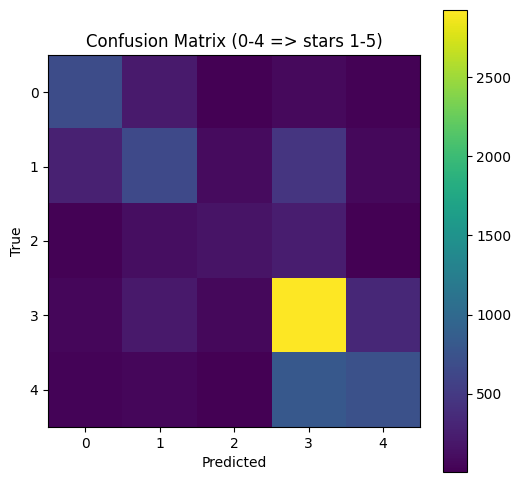

In [49]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Confusion Matrix (0-4 => stars 1-5)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


In [51]:
test_texts = tokenized["test"]
wrong_idx = np.where(y_true != y_pred)[0]

print("Wrong predictions:", len(wrong_idx), "out of", len(y_true))

for i in wrong_idx[:10]:
    print("="*80)
    print("TRUE:", int(y_true[i]+1), "| PRED:", int(y_pred[i]+1))
    print(test_texts[int(i)]['text'][:500])

Wrong predictions: 3175 out of 8323
TRUE: 5 | PRED: 4

                      izleyiciye beni izlemeyin der gibi bir film ama yine de mükemmel.
        
            
TRUE: 4 | PRED: 5

                      Bu film çok güzel çok büyük bir tablo.kimileri bu tabloda gizliden yapılmış yahudi propagandasını görüyor, kimisi savaş ortasında bir ticaret görüyor, kimiyse amerikan sinema sektörünün duygu sömürüsüyle para kazanmasını görüyor. ben bu tabloda insanın insana zulüm etmesini gördüm. zaman değişir, isimler değişir, roller değişir, ama zulüm değişmez. bu zulme kayıtsız kalmak da en az ona katılmak kadar suçtur. ben bu tabloda propaganda görmedim, çünkü kanım öylesine donmuştu
TRUE: 4 | PRED: 2

                      gerilim filmi değil kesinlikle,dram filmi olarak basarılı ama gerilimde sınıfta kaldı,hep bişeyler olacak diye bekliyorsunuz ama hiç birsey olmuyor! sadece birkac kişi ve onlar arasında dönüp duran olaylar,virüs kapmış insanlar yok.hastalık yok hiç birsey yok.bomboş bir sehi